In [1]:
from scdataloader import Preprocessor

from bengrn import BenGRN, get_sroy_gt, FILEDIR
import scanpy as sc

from anndata.utils import make_index_unique
from bengrn import get_GT_db
from grnndata import utils as grnutils
import pandas as pd
import numpy as np

%load_ext autoreload
%autoreload 2 

import torch
torch.set_float32_matmul_precision('medium')

→ connected lamindb: jkobject/scprint


In [2]:
import shutil
import os

from geneformer import EmbExtractor
from geneformer import TranscriptomeTokenizer
from grnndata import GRNAnnData

from geneformer import TOKEN_DICTIONARY_FILE
import pickle

with open(TOKEN_DICTIONARY_FILE, "rb") as f:
    gene_mapping_dict = pickle.load(f)

def compute_geneformer_network(adata, model="../../Geneformer/gf-12L-30M-i2048/", model_type="Pretrained", forward_batch_size=4, max_ncells=1000, ):
    adata = adata[:, adata.var.index.isin([u for u in gene_mapping_dict.keys() if u in adata.var.index])]
    adata.var['ensembl_id'] = adata.var.index
    adata.obs['n_counts'] = adata.X.sum(1)
    # Create the geneformer folder if it doesn't exist
    geneformer_folder = "/tmp/geneformer"
    if not os.path.exists(geneformer_folder):
        os.makedirs(geneformer_folder)
    adata.write_h5ad("/tmp/geneformer/test.h5ad")

    genelist = [gene_mapping_dict[u] for u in adata.var.index]

    tokenized_data_path = "/tmp/geneformer/tokenized_data.dataset/"
    if os.path.exists(tokenized_data_path):
        shutil.rmtree(tokenized_data_path)
    tk = TranscriptomeTokenizer(nproc=16, model_input_size=2048)
    tk.tokenize_data("/tmp/geneformer/", 
                    "/tmp/geneformer/",
                    "tokenized_data", 
                    file_format="h5ad")
    embex = EmbExtractor(model_type=model_type, #CellClassifier
                     max_ncells=max_ncells,
                     emb_mode="cell",
                     forward_batch_size=forward_batch_size,
                     nproc=16,
                     genelist=genelist)
    embs, avg_attentions = embex.extract_embs(model, #../../../Geneformer/fine_tuned_models/gf-6L-30M-i2048_CellClassifier_cardiomyopathies_220224/
                          "/tmp/geneformer/tokenized_data.dataset/",
                          "/tmp/geneformer",
                          "geneformertest",
                          get_avg_attentions=True,
                          )
    return GRNAnnData(adata.copy(), grn=avg_attentions.to("cpu").numpy())

In [3]:
#genes = torch.load('/pasteur/zeus/projets/p02/ml4ig_hot/Users/jkalfon/scprint_scale/o2uniqsx/checkpoints/epoch=18-step=133000.ckpt', map_location=torch.device('cpu'))['hyper_parameters']['genes']

genes = torch.load('../data/temp/vbd8bavn/epoch=17-step=90000.ckpt', map_location=torch.device('cpu'))['hyper_parameters']['genes']

preprocessor = Preprocessor(is_symbol=True, force_preprocess=True, skip_validate=True,
                            do_postp=False, min_valid_genes_id=5000, min_dataset_size=64)
NUM_GENES = 5000
MAXCELLS = 1024

# han / full


In [4]:
metrics = {}

In [5]:
preadata = get_sroy_gt(get="han", species="human", gt="full")
adata = preprocessor(preadata.copy())
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.TF), "isTF"] = True
adata = adata[:, adata.var.index.isin(genes)]
preadata, (preadata.grn.sum(1) != 0).sum()

Dropping layers:  KeysView(Layers with keys: )
checking raw counts
removed 0 non primary cells, 5520 renamining
filtered out 0 cells, 5520 renamining
No ENSG genes found, assuming gene symbols...
Removed 0 genes.
startin QC
Seeing 151 outliers (2.74% of total dataset):


/home/ml4ig1/Documents code/scDataLoader/scdataloader/preprocess.py:350: ImplicitModificationWarning: Trying to modify index of attribute `.obs` of view, initializing view as actual.
  adata.obs.index = [str(uuid4()) for _ in range(adata.shape[0])]


done


(GRnnData object with n_obs × n_vars = 5520 × 7465
     obs: 'organism_ontology_term_id'
     varp: 'GRN'
     with a grn of 8463 elements,
 31)

In [6]:
sc.pp.highly_variable_genes(
    adata, flavor="seurat_v3", n_top_genes=NUM_GENES)
adata.var['ensembl_id'] = adata.var.index
subadata = adata[:MAXCELLS, adata.var.highly_variable]

grn = compute_geneformer_network(subadata)
grn.var['symbol'] = make_index_unique(
    grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']

/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:172: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}
/tmp/ipykernel_2358115/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad
/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


Creating dataset.


BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is N

  0%|          | 0/250 [00:00<?, ?it/s]

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


precision:  0.027869206027700415 
recall:  0.9877035559986707 
random precision: 0.027398382867132868


  0%|          | 0/128 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 2080.02it/s]

Average Precision (AP):  0.030384214147381558
Area Under Precision-Recall Curve (AUPRC):  0.03030317361725128
EPR: 0.5197682916772122


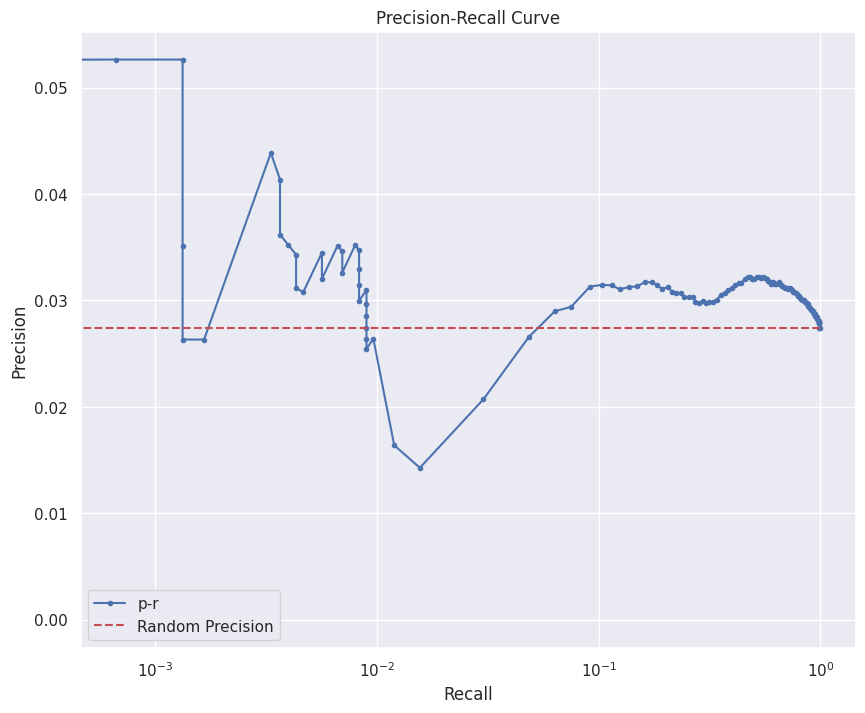

In [7]:
grn.varp["GRN"] = grn.varp["GRN"].T
metrics['geneformer_han'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

base enrichment
Top central genes: []


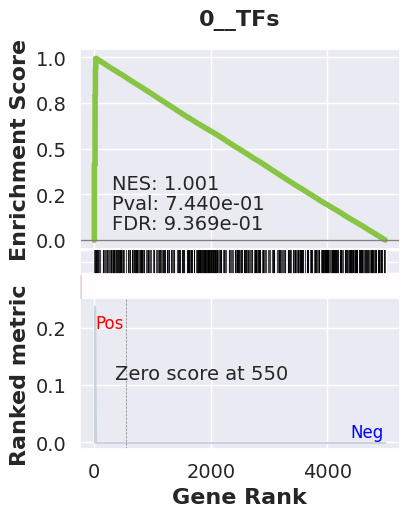

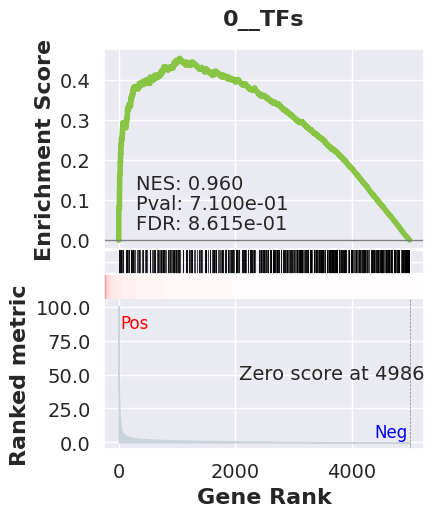

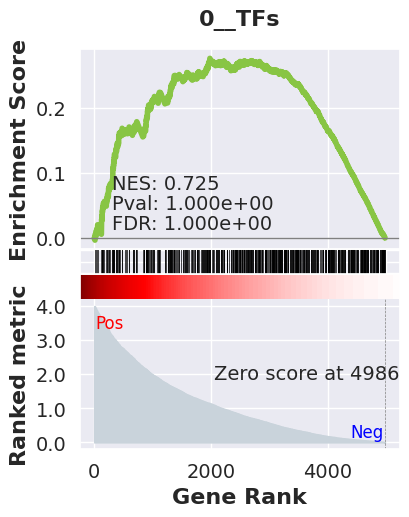

_________________________________________
TF specific enrichment
found some significant results for  58.490566037735846 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3761 genes
intersection pct: 0.7532545563789305
precision:  0.0015314356254061677 
recall:  0.9647003963627885 
random precision: 0.0015164736630705958


 98%|█████████▊| 126/128 [00:04<00:00, 36.93it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:04<00:00, 31.30it/s]


Average Precision (AP):  0.0018174213001598094
Area Under Precision-Recall Curve (AUPRC):  0.0018060245708259905
EPR: 2.5020406423641415


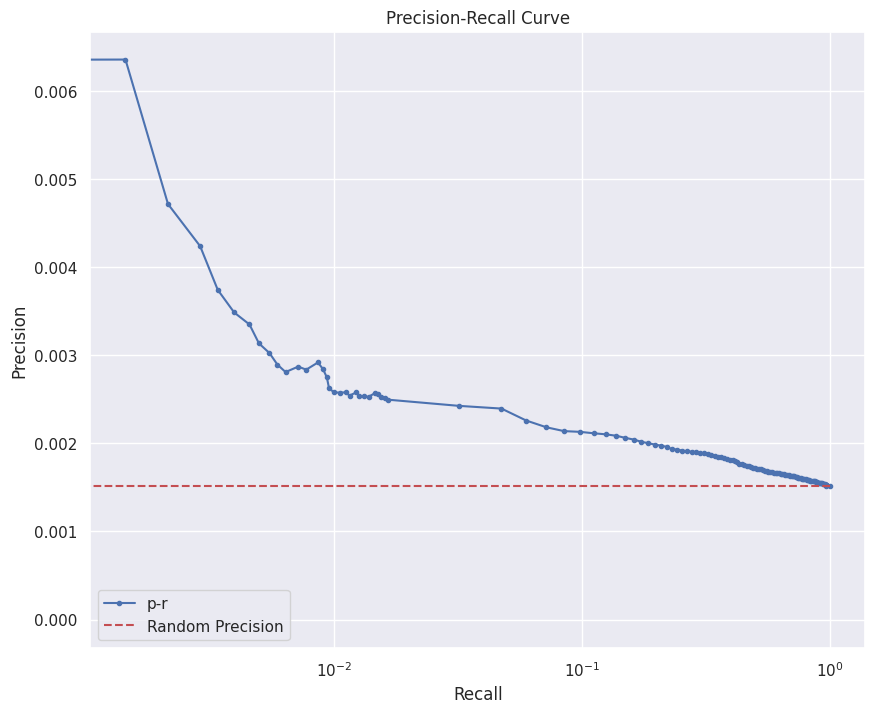

In [8]:
grn.varp["GRN"] = grn.varp["GRN"].T
metrics['geneformer_han_base'] = BenGRN(grn, do_auc=True, doplot=True).scprint_benchmark()

precision:  0.2565443983732958 
recall:  0.9935420441839843 
random precision: 0.2534494215134459


 98%|█████████▊| 126/128 [00:00<00:00, 603.57it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 600.08it/s]


Average Precision (AP):  0.3035700166296099
Area Under Precision-Recall Curve (AUPRC):  0.3034209752404555
EPR: 1.650604573602947


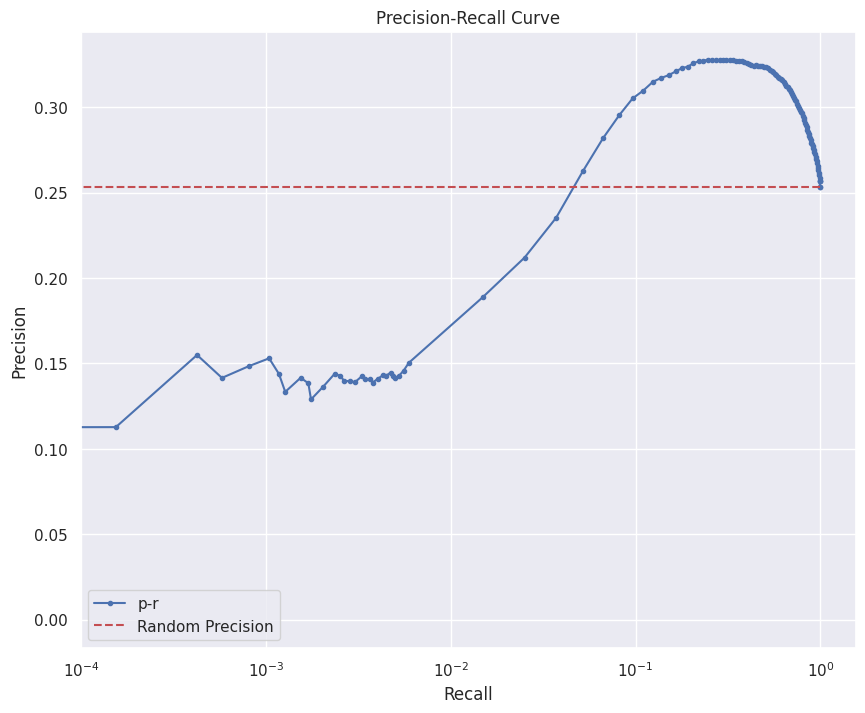

In [9]:
preadata = get_sroy_gt(get="han", species="human", gt="chip")
grn.varp["GRN"] = grn.varp["GRN"].T
metrics['geneformer_han_chip'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

precision:  0.07536310077402389 
recall:  0.9325163398692811 
random precision: 0.07594452008168823


 83%|████████▎ | 106/128 [00:00<00:00, 364.26it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 361.12it/s]


Average Precision (AP):  0.0656634552906704
Area Under Precision-Recall Curve (AUPRC):  0.06553080397964073
EPR: 0.8493989991492181


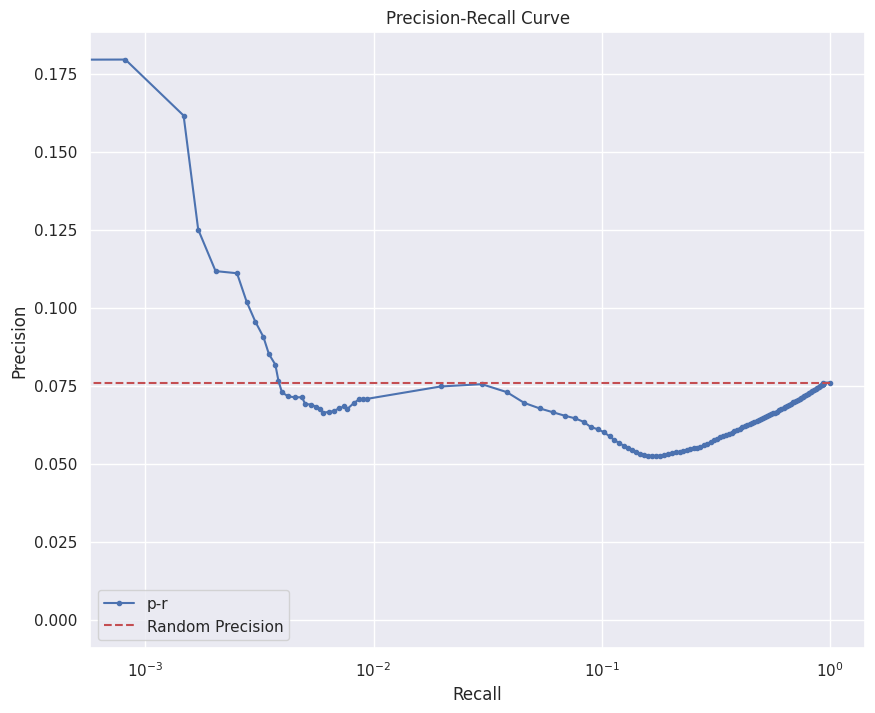

In [10]:
preadata = get_sroy_gt(get="han", species="human", gt="ko")
metrics['geneformer_han_ko'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

## trial with my own ESC

In [11]:
preadata = get_sroy_gt(get="mine", species="human", gt="full")
adata = preprocessor(preadata.copy())
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.TF), "isTF"] = True
preadata, (preadata.grn.sum(1) != 0).sum()

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:513: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["ensembl_id"] = adata.var.index


Dropping layers:  KeysView(Layers with keys: )
checking raw counts
Data is not raw counts, please check layers, find raw data, or bypass with force_preprocess
removed 0 non primary cells, 115 renamining
filtered out 0 cells, 115 renamining
Removed 0 genes.
startin QC
Seeing 104 outliers (90.43% of total dataset):


/home/ml4ig1/Documents code/scDataLoader/scdataloader/preprocess.py:350: ImplicitModificationWarning: Trying to modify index of attribute `.obs` of view, initializing view as actual.
  adata.obs.index = [str(uuid4()) for _ in range(adata.shape[0])]


done


(GRnnData object with n_obs × n_vars = 115 × 28490
     obs: 'organism_ontology_term_id'
     var: 'ensembl_id'
     varp: 'GRN'
     with a grn of 11565 elements,
 35)

/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/tmp/ipykernel_2358115/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad
/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


Creating dataset.


/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
[d3graph] WARNING> CLS token present in token dictionary, excluding from average.
[d3graph] WARNING> EOS token present in token dictionary, excluding from average.


  0%|          | 0/29 [00:00<?, ?it/s]

precision:  0.03252084019560646 
recall:  0.9899730042421905 
random precision: 0.03184916784376343


  0%|          | 0/128 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 3933.26it/s]

Average Precision (AP):  0.040403303377491054
Area Under Precision-Recall Curve (AUPRC):  0.03998519693798022
EPR: 0.16048163042054858


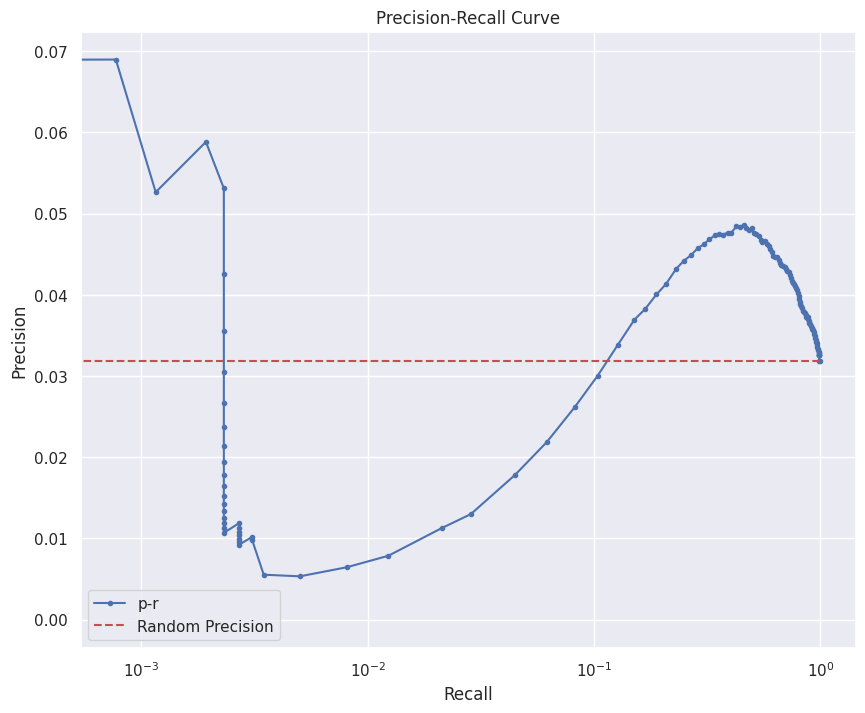

base enrichment
Top central genes: []


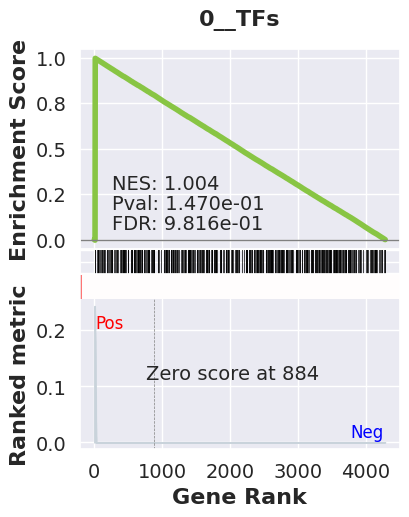

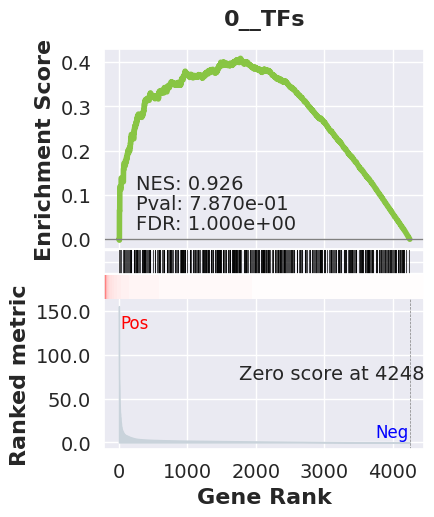

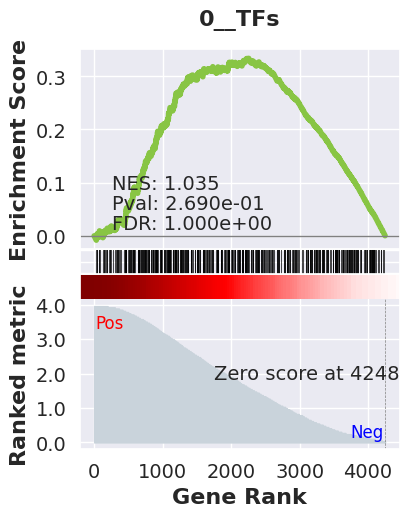

_________________________________________
TF specific enrichment
found some significant results for  72.5 % TFs

_________________________________________
loading GT,  omnipath
intersection of 2829 genes
intersection pct: 0.6600559962669156
precision:  0.0015599051373871144 
recall:  0.9445181622159562 
random precision: 0.001507172380622398


 95%|█████████▌| 122/128 [00:01<00:00, 70.25it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:01<00:00, 73.01it/s]


Average Precision (AP):  0.0017899726852917224
Area Under Precision-Recall Curve (AUPRC):  0.0017828801288741472
EPR: 1.9867914202988526


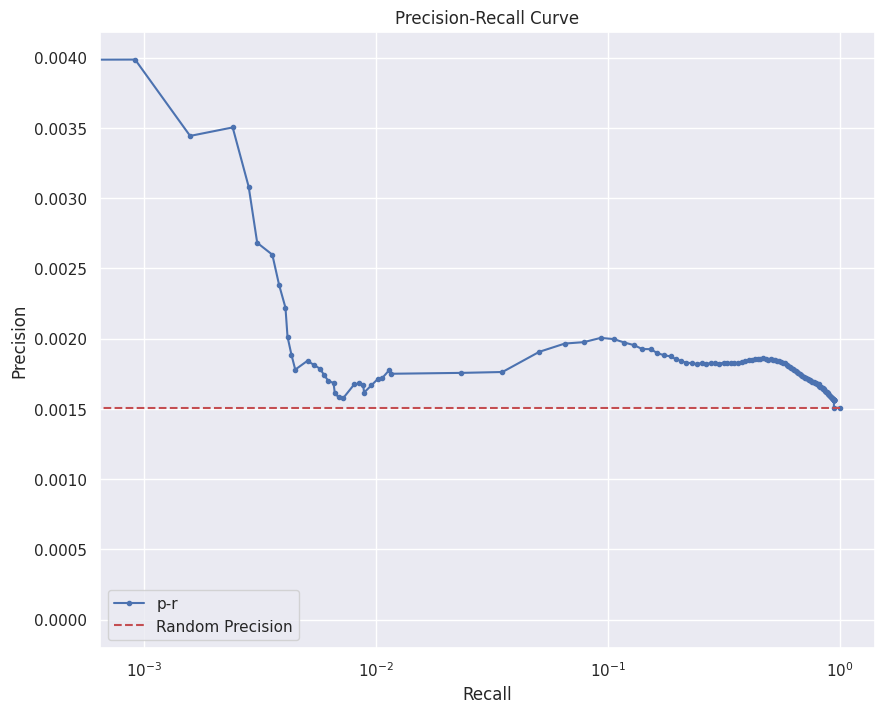

In [12]:
sc.pp.highly_variable_genes(
    adata, flavor="seurat_v3", n_top_genes=NUM_GENES)
adata.var['ensembl_id'] = adata.var.index
subadata = adata[:MAXCELLS, adata.var.index.isin(
    genes) & adata.var.highly_variable]

grn = compute_geneformer_network(subadata)

grn.var['symbol'] = make_index_unique(
    grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']
grn.varp["GRN"] = grn.varp["GRN"].T
metrics['geneformer_mine'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)
grn.varp["GRN"] = grn.varp["GRN"].T
metrics['geneformer_mine_base'] = BenGRN(grn, do_auc=True, doplot=True).scprint_benchmark()

base enrichment
Top central genes: []


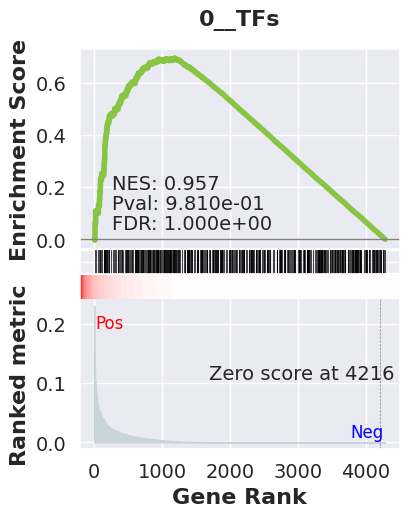

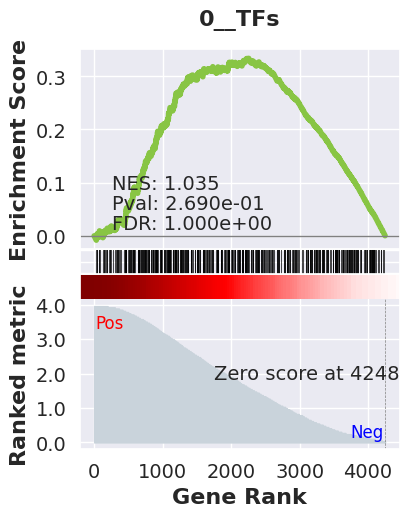

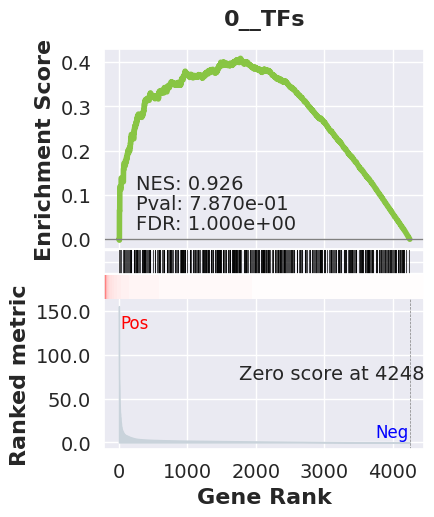

_________________________________________
TF specific enrichment
found some significant results for  17.5 % TFs

_________________________________________
loading GT,  omnipath
intersection of 2829 genes
intersection pct: 0.6600559962669156
precision:  0.0015599051373871144 
recall:  0.9445181622159562 
random precision: 0.001507172380622398


 98%|█████████▊| 126/128 [00:01<00:00, 77.80it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:01<00:00, 77.81it/s]


Average Precision (AP):  0.0017533884184601646
Area Under Precision-Recall Curve (AUPRC):  0.0017499980410318541
EPR: 1.3771929750044907


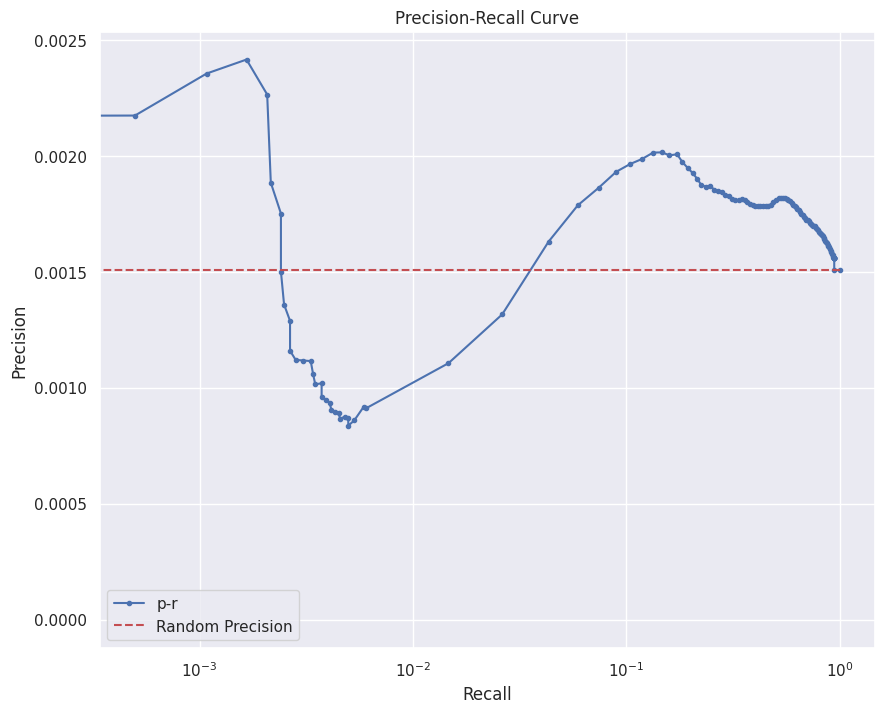

In [13]:
grn.varp["GRN"] = grn.varp["GRN"].T
metrics['geneformer_mine_base'] = BenGRN(grn, do_auc=True, doplot=True).scprint_benchmark()

/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/tmp/ipykernel_2358115/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad
/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


Creating dataset.


/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
[d3graph] WARNING> CLS token present in token dictionary, excluding from average.
[d3graph] WARNING> EOS token present in token dictionary, excluding from average.


  0%|          | 0/29 [00:00<?, ?it/s]

precision:  0.03252084019560646 
recall:  0.9899730042421905 
random precision: 0.03184916784376343


  0%|          | 0/128 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 4257.97it/s]

Average Precision (AP):  0.040403303377491054
Area Under Precision-Recall Curve (AUPRC):  0.03998519693798022
EPR: 0.16048163042054858


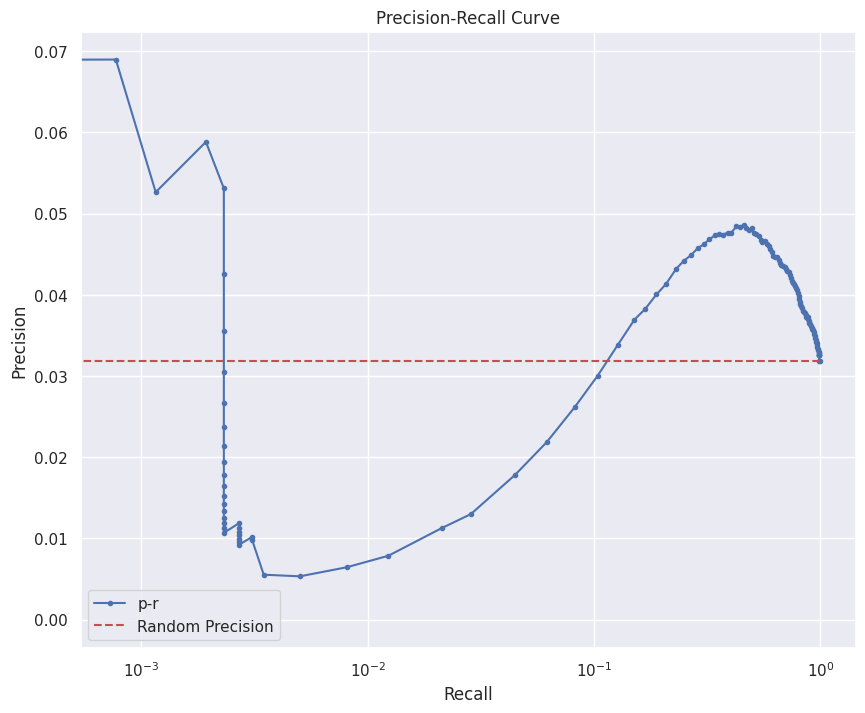

In [14]:
sc.pp.highly_variable_genes(
    adata, flavor="seurat_v3", n_top_genes=NUM_GENES)
adata.var['ensembl_id'] = adata.var.index
subadata = adata[:MAXCELLS, adata.var.index.isin(
    genes) & adata.var.highly_variable]
grn = compute_geneformer_network(subadata)
grn.var['symbol'] = make_index_unique(
    grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']
grn.varp["GRN"] = grn.varp["GRN"].T
metrics['geneformer_mine'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

base enrichment
Top central genes: []


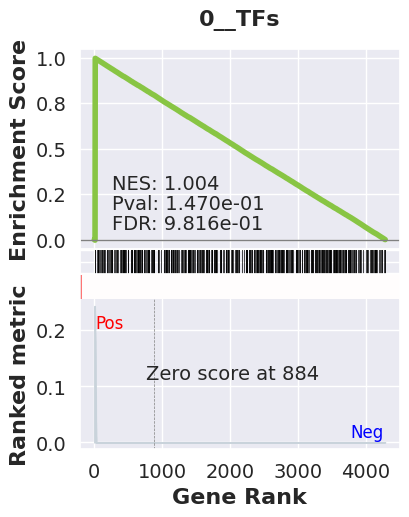

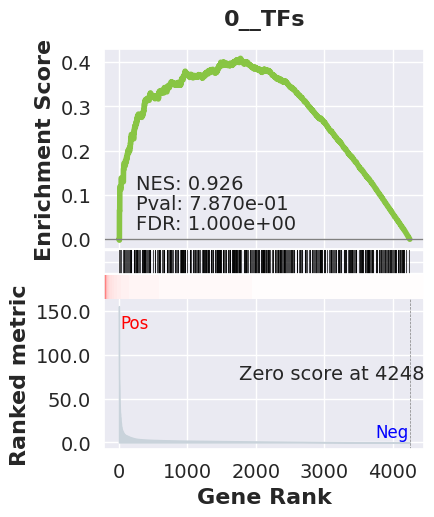

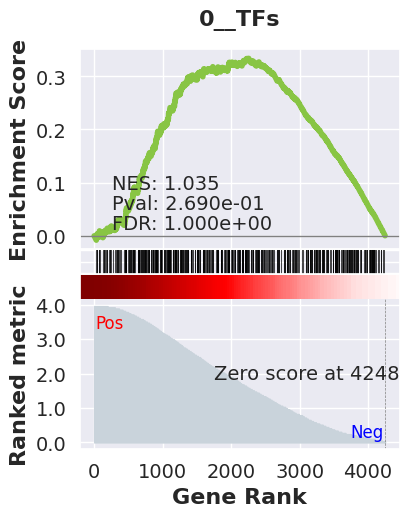

_________________________________________
TF specific enrichment
found some significant results for  72.5 % TFs

_________________________________________
loading GT,  omnipath
intersection of 2829 genes
intersection pct: 0.6600559962669156
precision:  0.0015599051373871144 
recall:  0.9445181622159562 
random precision: 0.001507172380622398


 96%|█████████▌| 123/128 [00:01<00:00, 76.66it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:01<00:00, 75.85it/s]


Average Precision (AP):  0.0017899726852917224
Area Under Precision-Recall Curve (AUPRC):  0.0017828801288741472
EPR: 1.9867914202988526


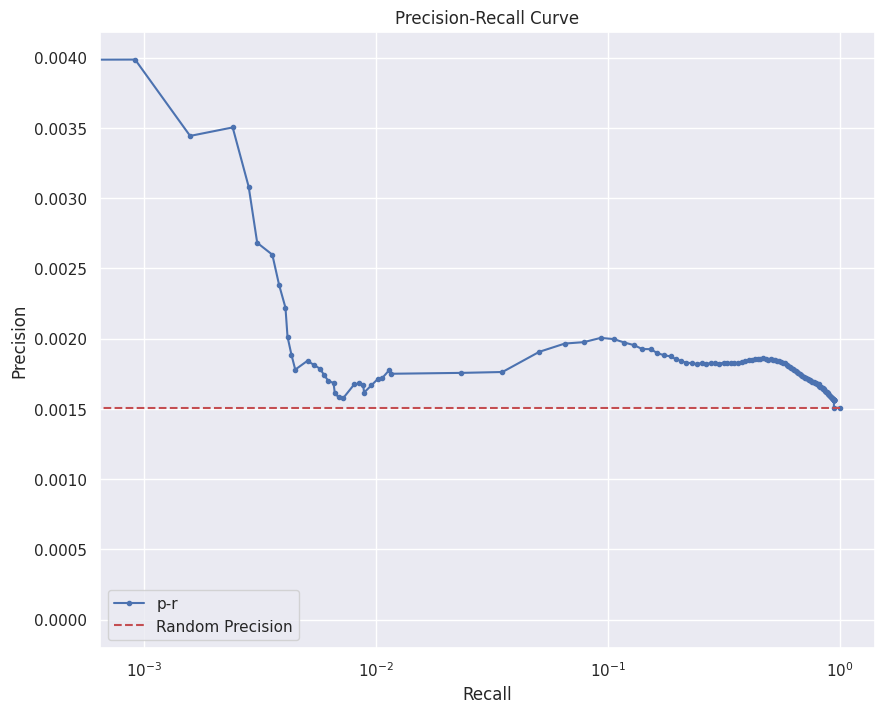

In [15]:
grn.varp["GRN"] = grn.varp["GRN"].T
metrics['geneformer_mine_base'] = BenGRN(grn, do_auc=True, doplot=True).scprint_benchmark()

In [18]:
metrics

{'geneformer_han': {'precision': 0.027869206027700415,
  'recall': 0.9877035559986707,
  'rand_precision': 0.027398382867132868,
  'auprc': 0.03030317361725128,
  'ap': 0.030384214147381558,
  'epr': 0.5197682916772122},
 'geneformer_han_base': {'TF_enr': False,
  'enriched_terms_Targets': ['celltype.gmt__Naive B cells',
   'celltype.gmt__Memory B cells',
   'celltype.gmt__Plasma B cells',
   'celltype.gmt__Embryonic stem cells',
   'celltype.gmt__Pre-B cells',
   'celltype.gmt__HSC/MPP cells',
   'celltype.gmt__Endothelial',
   'celltype.gmt__Pro-B cells',
   'celltype.gmt__Hepatoblasts'],
  'significant_enriched_TFtargets': 58.490566037735846,
  'precision': 0.0015314356254061677,
  'recall': 0.9647003963627885,
  'rand_precision': 0.0015164736630705958,
  'auprc': 0.0018060245708259905,
  'ap': 0.0018174213001598094,
  'epr': 2.5020406423641415},
 'geneformer_han_chip': {'precision': 0.2565443983732958,
  'recall': 0.9935420441839843,
  'rand_precision': 0.2534494215134459,
  'auprc

In [19]:
res = []
res2 = []
for k, v in metrics.items():
    if k.split('_')[-1] == "base":
        res2.append([k.split('_')[-2], v['epr'], v['auprc'], v['rand_precision'], v['significant_enriched_TFtargets'], v.get('TF_enr', False), 'tf_' in k])
    elif k.split('_')[-1] == "ko":
        res.append([k.split('_')[-2]+"_ko", v['epr'], v['auprc'], v['rand_precision'], 'tf_' in k])
    elif k.split('_')[-1] == "chip":
        res.append([k.split('_')[-2]+"_chip", v['epr'], v['auprc'], v['rand_precision'], 'tf_' in k])
    else:
        res.append([k.split('_')[-1], v['epr'], v['auprc'], v['rand_precision'], 'tf_' in k])

df = pd.DataFrame(res, columns=['name','EPR', 'AUPRC', 'RAND', 'TF_only'])
df2 = pd.DataFrame(res2, columns=['name','EPR', 'AUPRC', 'RAND', 'TF_targ', 'TF_enr', 'TF_only'])
df

,name,EPR,AUPRC,RAND,TF_only
0,han,0.519768,0.030303,0.027398,False
1,han_chip,1.650605,0.303421,0.253449,False
2,han_ko,0.849399,0.065531,0.075945,False
3,mine,0.160482,0.039985,0.031849,False


In [20]:
df2

,name,EPR,AUPRC,RAND,TF_targ,TF_enr,TF_only
0,han,2.502041,0.001806,0.001516,58.490566,False,False
1,mine,1.986791,0.001783,0.001507,72.500000,False,False
